# **Código Jupyter Notebook Trabajo de Fin de Máster**

Autor: Nicolás Goyena Serveto, Julio 2025

Aclaración: Para reducir el tamaño del código y centrarse con claridad en los resultados descritos de la memoria de TFM, el código mostrado aquí ha sido el que se ha usado para generar los resultados finales descritos. Todas las pruebas (uso de Machine Learning, pruebas de ajuste de funciones...) no se ha incluido.

# Ficocianina en El Val

## Importación de Datos El Val

In [4]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/HIBLOOMS/datos_sensores_totales_2_7.csv")
# Renombrar las columnas
df = df.rename(columns={'date_time': 'Fecha', 'phycocyanin': 'Valor'})

# Conservar solo las columnas renombradas
df = df[['Fecha', 'Valor']]

df['Fecha'] = pd.to_datetime(df['Fecha'])

# Definir el periodo de mantenimiento y eliminar datos no válidos correspondientes
inicio = pd.to_datetime('2024-11-13').tz_localize('UTC')
fin = pd.to_datetime('2024-12-11').tz_localize('UTC')
mask = (df['Fecha'] >= inicio) & (df['Fecha'] <= fin)
df = df[~mask]

# Lista de horas a eliminar del 12/12 (día en que se acabó el periodo de mantenimiento)
fechas_a_eliminar = [
    "2024-12-12 00:30:00+00:00", "2024-12-12 01:00:00+00:00", "2024-12-12 01:30:00+00:00",
    "2024-12-12 02:00:00+00:00", "2024-12-12 02:30:00+00:00", "2024-12-12 03:00:00+00:00",
    "2024-12-12 03:30:00+00:00", "2024-12-12 04:00:00+00:00", "2024-12-12 04:30:00+00:00",
    "2024-12-12 05:00:00+00:00", "2024-12-12 05:30:00+00:00", "2024-12-12 06:00:00+00:00",
    "2024-12-12 06:30:00+00:00", "2024-12-12 07:00:00+00:00", "2024-12-12 07:30:00+00:00",
    "2024-12-12 08:00:00+00:00", "2024-12-12 08:30:00+00:00", "2024-12-12 09:00:00+00:00",
    "2024-12-12 09:30:00+00:00", "2024-12-12 10:00:00+00:00", "2024-12-12 10:30:00+00:00"
]

# Convertir a objetos datetime con zona horaria UTC
fechas_a_eliminar = pd.to_datetime(fechas_a_eliminar).tz_convert('UTC')

# Filtrar el DataFrame para quitar esas fechas
df = df[~df['Fecha'].isin(fechas_a_eliminar)]
df['Fecha'] = df['Fecha'].dt.strftime('%d-%m-%Y %H:%M')

In [5]:
#Calcular valores de percentiles
percentil_90 = df['Valor'].quantile(0.90)
percentil_95 = df['Valor'].quantile(0.95)
percentil_99 = df['Valor'].quantile(0.9975)

print(f"Percentil 90: {percentil_90:.2f} µg/L")
print(f"Percentil 95: {percentil_95:.2f} µg/L")
print(f"Percentil 99: {percentil_99:.2f} µg/L")

Percentil 90: 10.35 µg/L
Percentil 95: 20.15 µg/L
Percentil 99: 78.97 µg/L


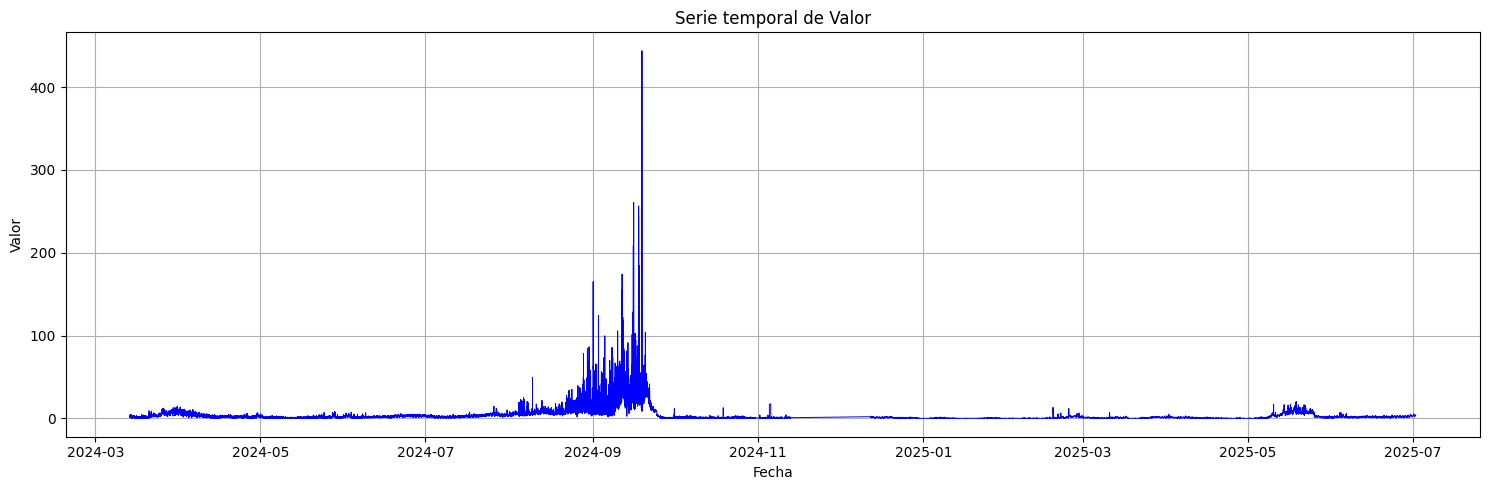

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d-%m-%Y %H:%M")
df = df.sort_values('Fecha')

plt.figure(figsize=(15,5))
plt.plot(df['Fecha'], df['Valor'], color='blue', linewidth=0.7)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Serie temporal de Valor')
plt.grid(True)
plt.tight_layout()
plt.show()


## Asociación de imágenes con mediciones

In [7]:
import ee
import pandas as pd
from datetime import datetime

# Inicializar Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-nicolasgoyenaserveto')

# Definir el punto de la sonda
lat = 41.8761
lon = -1.7883
punto_val3 = ee.Geometry.Point([lon, lat])

# Rango de fechas
fecha_inicio = "2024-03-13"
fecha_fin = datetime.today().strftime('%Y-%m-%d')

# Filtrar colección Sentinel-2 (sin filtro de nubosidad)
coleccion = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(punto_val3) \
    .filterDate(fecha_inicio, fecha_fin)

# Obtener fechas únicas
timestamps = coleccion.aggregate_array('system:time_start').getInfo()
fechas_unicas = sorted(set(
    [datetime.utcfromtimestamp(ts / 1000).strftime("%Y-%m-%d") for ts in timestamps]
))

resultados = []

for fecha in fechas_unicas:
    inicio_ee = ee.Date(fecha)
    fin_ee = inicio_ee.advance(1, 'day')

    imagen = coleccion.filterDate(inicio_ee, fin_ee).sort('system:time_start').first()

    if imagen is None:
        print(f"No se encontró imagen para {fecha}")
        continue

    imagen = ee.Image(imagen).clip(punto_val3)

    # Comprobar la clase SCL en el punto
    scl = imagen.select('SCL')
    clase_punto = scl.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=punto_val3,
        scale=20
    ).get('SCL')

    try:
        valor_clase = clase_punto.getInfo()
    except:
        valor_clase = None

    if valor_clase in [7, 8, 9, 10]:  # sombra, nube, cirros
        print(f"{fecha}: punto cubierto por nubes (SCL={valor_clase}), se descarta")
        continue

    # Calcular PCI = B5 / B4, tras escalar bandas
    b4 = imagen.select('B4').divide(10000)
    b5 = imagen.select('B5').divide(10000)
    pci = b5.divide(b4).rename('PCI')

    # Obtener valor de PCI con reduceRegion
    pci_valor = pci.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=punto_val3,
        scale=20
    )

    try:
        pci_info = pci_valor.getInfo()
        fila = {"Date": fecha, "PCI": pci_info.get('PCI', None)}
        resultados.append(fila)
        print(f"{fecha}: PCI = {fila['PCI']}")
    except Exception as e:
        print(f"Error al obtener PCI para {fecha}: {e}")

# Convertir los resultados a un DataFrame y exportar a CSV
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("VAL3_PCI_optimizado.csv", index=False)
print("Archivo CSV generado: VAL3_PCI_optimizado.csv")



2024-03-13: punto cubierto por nubes (SCL=10), se descarta
2024-03-18: PCI = 1.2380952380952381
2024-03-23: punto cubierto por nubes (SCL=10), se descarta
2024-03-28: punto cubierto por nubes (SCL=9), se descarta
2024-04-02: punto cubierto por nubes (SCL=8), se descarta
2024-04-07: PCI = 0.9514563106796116
2024-04-12: PCI = 0.8767123287671234
2024-04-17: punto cubierto por nubes (SCL=9), se descarta
2024-04-22: PCI = 1.22265625
2024-04-27: punto cubierto por nubes (SCL=10), se descarta
2024-05-02: PCI = 1.0228310502283104
2024-05-07: PCI = 1.1244239631336406
2024-05-12: punto cubierto por nubes (SCL=8), se descarta
2024-05-17: punto cubierto por nubes (SCL=9), se descarta
2024-05-22: punto cubierto por nubes (SCL=9), se descarta
2024-05-27: punto cubierto por nubes (SCL=9), se descarta
2024-06-01: punto cubierto por nubes (SCL=9), se descarta
2024-06-06: PCI = 0.9911190053285968
2024-06-11: punto cubierto por nubes (SCL=9), se descarta
2024-06-16: PCI = 1.1016597510373445
2024-06-21: p

In [90]:
import pandas as pd

ruta_archivo = '/content/VAL3_PCI_optimizado.csv'
val3pci = pd.read_csv(ruta_archivo)
val3pci = val3pci[val3pci["PCI"] <= 10]
val3pci = val3pci[val3pci["PCI"].notna()]

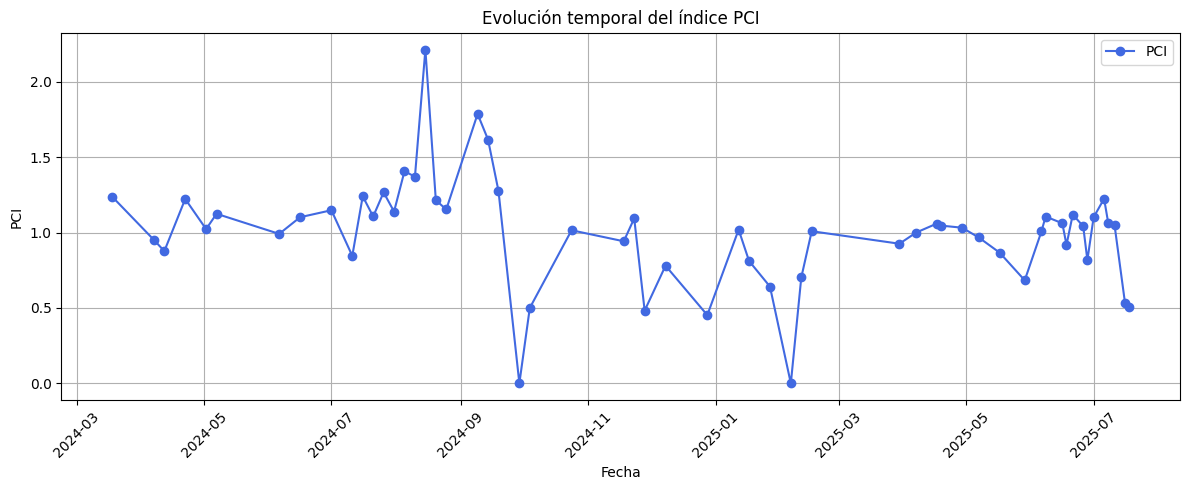

In [91]:
import matplotlib.pyplot as plt
import pandas as pd

val3pci['Date'] = pd.to_datetime(val3pci['Date'])
val3pci = val3pci.sort_values('Date')

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(val3pci['Date'], val3pci['PCI'], marker='o', linestyle='-', color='royalblue', label='PCI')

plt.title('Evolución temporal del índice PCI')
plt.xlabel('Fecha')
plt.ylabel('PCI')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


In [10]:
# Convertir la columna 'Fecha' de ambos DataFrames a datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])
val3pci['Date'] = pd.to_datetime(val3pci['Date'])

# Extraer solo la parte de la fecha para comparar días
df['date_only'] = df['Fecha'].dt.date
val3pci['date_only'] = val3pci['Date'].dt.date

# Filtrar df para conservar solo los días que están en val3pc
fechas_comunes = set(val3pci['date_only'])
df_filtrado = df[df['date_only'].isin(fechas_comunes)].copy()

# Seleccionar las filas de df filtrado que correspondan exactamente a las 11:00
# (siempre que los registros tengan esa hora exacta)
df_11 = df_filtrado[df_filtrado['Fecha'].dt.strftime('%H:%M:%S') == '11:00:00'].copy()


print(df_11)

import pandas as pd

# Asegurar que las columnas 'PC' de val3pc y 'Valor' de df_11 sean numéricas
val3pci['PCI'] = pd.to_numeric(val3pci['PCI'].astype(str).str.replace(',', '.'), errors='coerce')
df_11['Valor'] = pd.to_numeric(df_11['Valor'].astype(str).str.replace(',', '.'), errors='coerce')

# Asegurar que las fechas sean comparables (sin hora)
val3pci['Date'] = pd.to_datetime(val3pci['Date']).dt.date
df_11['Fecha'] = pd.to_datetime(df_11['Fecha']).dt.date

# Fusionar ambos DataFrames en uno solo, basado en la fecha
df_merged = val3pci[['Date', 'PCI']].merge(df_11[['Fecha', 'Valor']], left_on='Date', right_on='Fecha', how='inner')
df_merged = df_merged.drop([14,16,18,21])
# Calcular la correlación de Pearson entre PC y Valor
correlacion = df_merged['PCI'].corr(df_merged['Valor'])

print(f"Correlación entre PCI y Valor: {correlacion:.4f}")


                    Fecha  Valor   date_only
1346  2024-03-18 11:00:00   1.40  2024-03-18
7094  2024-04-07 11:00:00   2.32  2024-04-07
8533  2024-04-12 11:00:00   2.11  2024-04-12
11410 2024-04-22 11:00:00   0.85  2024-04-22
14290 2024-05-02 11:00:00   0.26  2024-05-02
15730 2024-05-07 11:00:00   1.64  2024-05-07
24368 2024-06-06 11:00:00   0.00  2024-06-06
27246 2024-06-16 11:00:00   1.85  2024-06-16
31562 2024-07-01 11:00:00   2.50  2024-07-01
34442 2024-07-11 11:00:00   1.57  2024-07-11
35882 2024-07-16 11:00:00   2.36  2024-07-16
37319 2024-07-21 11:00:00   2.71  2024-07-21
38759 2024-07-26 11:00:00   4.58  2024-07-26
40199 2024-07-31 11:00:00   3.32  2024-07-31
41635 2024-08-05 11:00:00  20.88  2024-08-05
43075 2024-08-10 11:00:00   6.23  2024-08-10
44515 2024-08-15 11:00:00   9.29  2024-08-15
45955 2024-08-20 11:00:00   6.43  2024-08-20
47395 2024-08-25 11:00:00  11.60  2024-08-25
51683 2024-09-09 11:00:00  29.85  2024-09-09
53121 2024-09-14 11:00:00  10.58  2024-09-14
54559 2024

In [11]:
import pandas as pd
import numpy as np
import plotly.express as px


# Calcular la correlación
correlacion = df_merged["PCI"].corr(df_merged["Valor"])

# Crear el scatterplot interactivo con Plotly
fig = px.scatter(
    df_merged,
    x="PCI",
    y="Valor",
    title=f"Correlación entre PCI y PC Real: {correlacion:.4f}",
    labels={"PCI": "PCI", "Valor": "PC Real"},
    trendline="ols",  # Añade línea de regresión
    hover_data=["PCI", "Valor"]
)

# Mostrar
fig.show()


Parámetros optimizados: k = 4.6755, x0 = 1.9895
R² = 0.9084, RMSE = 1.4112


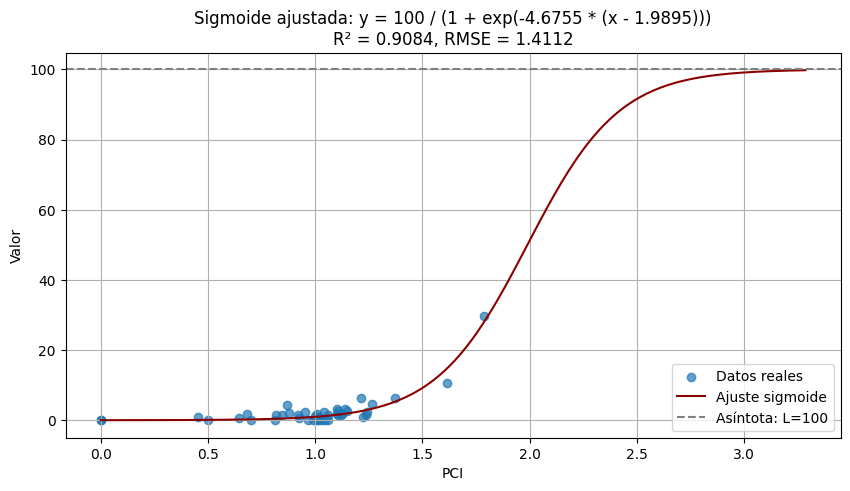

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

# Datos reales
x = df_merged['PCI'].values
y = df_merged['Valor'].values

# Valor máximo (asíntota superior)
L = 100

# Función logística con L fijo
def logistic_fixed_L(x, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Ajuste no lineal
popt, _ = curve_fit(logistic_fixed_L, x, y, p0=[1, np.median(x)], maxfev=10000)
k_opt, x0_opt = popt

# Predicción y métricas
y_pred = logistic_fixed_L(x, k_opt, x0_opt)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Redondear para el título
k_rounded = round(k_opt, 4)
x0_rounded = round(x0_opt, 4)
r2_rounded = round(r2, 4)
rmse_rounded = round(rmse, 4)

# Imprimir en consola
print(f"Parámetros optimizados: k = {k_rounded}, x0 = {x0_rounded}")
print(f"R² = {r2_rounded}, RMSE = {rmse_rounded}")

# Visualización
x_line = np.linspace(min(x), max(x) + 1.5, 200)
y_line = logistic_fixed_L(x_line, k_opt, x0_opt)

plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='Datos reales', alpha=0.7)
plt.plot(x_line, y_line, color='darkred', label='Ajuste sigmoide')
plt.axhline(L, linestyle='--', color='gray', label=f'Asíntota: L={L}')

# Título con parámetros redondeados
plt.title(
    f"Sigmoide ajustada: y = {L} / (1 + exp(-{k_rounded} * (x - {x0_rounded})))\n"
    f"R² = {r2_rounded}, RMSE = {rmse_rounded}"
)

plt.xlabel("PCI")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()



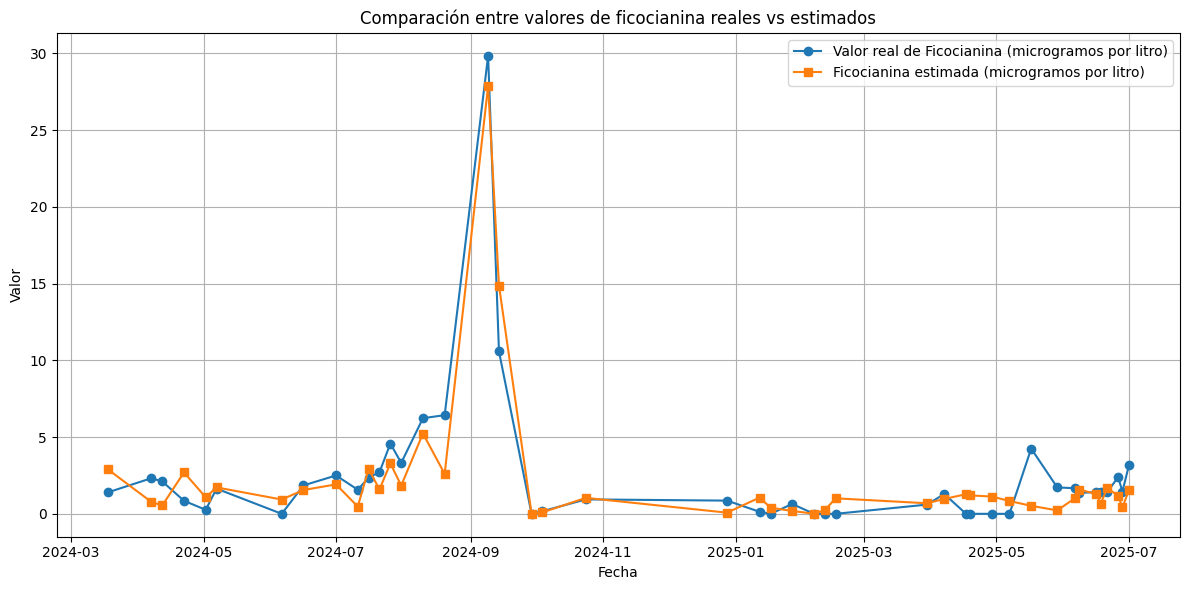

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Asegurarse de que 'Fecha' sea datetime
df_merged['Fecha'] = pd.to_datetime(df_merged['Fecha'])

# Función sigmoide definida
def sigmoid(x):
    return 100 / (1 + np.exp(-4.6755 * (x - 1.9895)))

# Aplicar la función a la columna PCI
df_merged['PCI_sigmoid'] = sigmoid(df_merged['PCI'])

# Graficar los valores reales y los transformados
plt.figure(figsize=(12, 6))
plt.plot(df_merged['Fecha'], df_merged['Valor'], label='Valor real de Ficocianina (microgramos por litro)', marker='o')
plt.plot(df_merged['Fecha'], df_merged['PCI_sigmoid'], label='Ficocianina estimada (microgramos por litro)', marker='s')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación entre valores de ficocianina reales vs estimados')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Cálculo Serie Histórica Ficocianina en El Val

In [94]:
import ee
import pandas as pd
from datetime import datetime

# Inicializar Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-nicolasgoyenaserveto')

# Definir el punto de la sonda
lat = 41.8761
lon = -1.7883
punto_val3 = ee.Geometry.Point([lon, lat])

# Rango de fechas
fecha_inicio = "2017-07-01"
fecha_fin = datetime.today().strftime('%Y-%m-%d')

# Filtrar colección Sentinel-2 (sin filtro de nubosidad)
coleccion = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(punto_val3) \
    .filterDate(fecha_inicio, fecha_fin)

# Obtener fechas únicas
timestamps = coleccion.aggregate_array('system:time_start').getInfo()
fechas_unicas = sorted(set(
    [datetime.utcfromtimestamp(ts / 1000).strftime("%Y-%m-%d") for ts in timestamps]
))

resultados = []

for fecha in fechas_unicas:
    inicio_ee = ee.Date(fecha)
    fin_ee = inicio_ee.advance(1, 'day')

    imagen = coleccion.filterDate(inicio_ee, fin_ee).sort('system:time_start').first()

    if imagen is None:
        print(f"No se encontró imagen para {fecha}")
        continue

    imagen = ee.Image(imagen).clip(punto_val3)

    # Comprobar la clase SCL en el punto
    scl = imagen.select('SCL')
    clase_punto = scl.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=punto_val3,
        scale=20
    ).get('SCL')

    try:
        valor_clase = clase_punto.getInfo()
    except:
        valor_clase = None

    if valor_clase in [7, 8, 9, 10]:  # sombra, nube, cirros
        print(f"{fecha}: punto cubierto por nubes (SCL={valor_clase}), se descarta")
        continue

    # Calcular PCI = B5 / B4, tras escalar bandas
    b4 = imagen.select('B4').divide(10000)
    b5 = imagen.select('B5').divide(10000)
    pci = b5.divide(b4).rename('PCI')

    # Obtener valor de PCI con reduceRegion
    pci_valor = pci.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=punto_val3,
        scale=20
    )

    try:
        pci_info = pci_valor.getInfo()
        fila = {"Date": fecha, "PCI": pci_info.get('PCI', None)}
        resultados.append(fila)
        print(f"{fecha}: PCI = {fila['PCI']}")
    except Exception as e:
        print(f"Error al obtener PCI para {fecha}: {e}")

# Convertir los resultados a un DataFrame y exportar a CSV
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("VAL3_PCI_optimizado.csv", index=False)
print("Archivo CSV generado: VAL3_PCI_optimizado.csv")


2017-07-18: PCI = 1.229041916167665
2017-07-28: PCI = 0.8270893371757925
2017-08-17: PCI = 1
2017-08-27: punto cubierto por nubes (SCL=9), se descarta
2017-09-06: PCI = 1.0594405594405594
2017-09-16: punto cubierto por nubes (SCL=9), se descarta
2017-10-06: PCI = 7.421052631578947
2017-10-16: PCI = 4
2017-10-26: PCI = 1
2017-11-05: punto cubierto por nubes (SCL=9), se descarta
2017-11-15: punto cubierto por nubes (SCL=8), se descarta
2017-11-25: punto cubierto por nubes (SCL=9), se descarta
2017-12-05: PCI = 1
2017-12-15: punto cubierto por nubes (SCL=9), se descarta
2017-12-20: PCI = 1
2017-12-25: punto cubierto por nubes (SCL=7), se descarta
2017-12-30: PCI = 0.05
2018-01-04: PCI = 0.44642857142857145
2018-01-09: punto cubierto por nubes (SCL=9), se descarta
2018-01-14: punto cubierto por nubes (SCL=9), se descarta
2018-01-19: PCI = 1
2018-01-24: PCI = 0.4615384615384615
2018-01-29: PCI = 1
2018-02-08: punto cubierto por nubes (SCL=8), se descarta
2018-02-13: punto cubierto por nubes

In [105]:
import pandas as pd
import numpy as np
ruta_archivo = '/content/VAL3_PCI_optimizado.csv'
val3pci = pd.read_csv(ruta_archivo)
val3pci = val3pci[val3pci["PCI"].notna()]
val3pci["PC_Val_cal"] = 100 / (1 + np.exp(-4.6755 * (val3pci["PCI"] - 1.9895)))
val3pci["PC_Val_cal"] = val3pci["PC_Val_cal"].clip(lower=0)

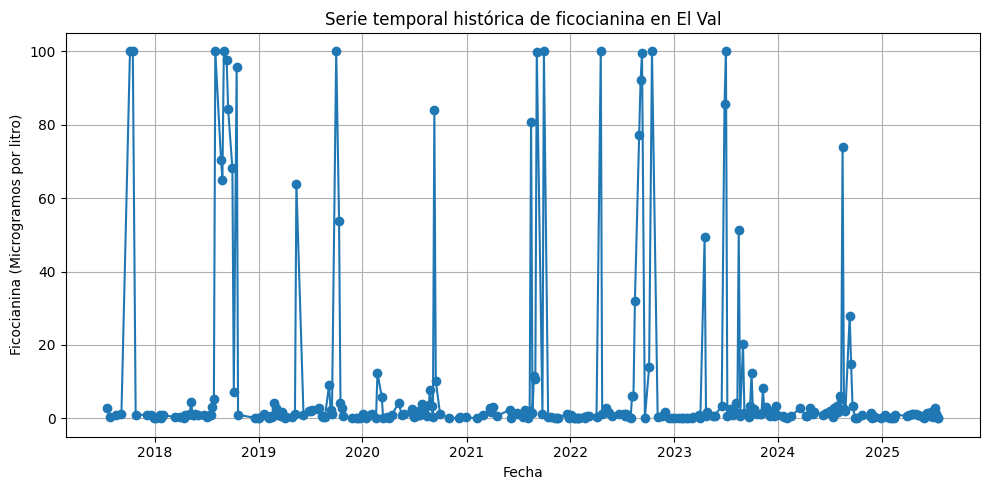

In [106]:
import matplotlib.pyplot as plt

val3pci["Date"] = pd.to_datetime(val3pci["Date"])
# Ordenar por fecha
val3pci = val3pci.sort_values("Date")

# Crear la gráfica
plt.figure(figsize=(10, 5))
plt.plot(val3pci["Date"], val3pci["PC_Val_cal"], marker='o', linestyle='-')
plt.xlabel("Fecha")
plt.ylabel("Ficocianina (Microgramos por litro)")
plt.title("Serie temporal histórica de ficocianina en El Val")
plt.grid(True)
plt.tight_layout()
plt.show()


## Cálculo Serie Histórica Ficocianina en Bellús

In [ ]:
import ee
import pandas as pd
from datetime import datetime

# Inicializar Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-nicolasgoyenaserveto')

# Definir el punto VAL-3
lat = 38.936974
lon = -0.479160
punto_val3 = ee.Geometry.Point([lon, lat])

# Rango de fechas
fecha_inicio = "2017-07-01"
fecha_fin = datetime.today().strftime('%Y-%m-%d')

# Filtrar colección Sentinel-2
coleccion = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(punto_val3) \
    .filterDate(fecha_inicio, fecha_fin)

# Obtener fechas únicas
timestamps = coleccion.aggregate_array('system:time_start').getInfo()
fechas_unicas = sorted(set(
    [datetime.utcfromtimestamp(ts / 1000).strftime("%Y-%m-%d") for ts in timestamps]
))

resultados = []

for fecha in fechas_unicas:
    inicio_ee = ee.Date(fecha)
    fin_ee = inicio_ee.advance(1, 'day')

    imagen = coleccion.filterDate(inicio_ee, fin_ee).sort('system:time_start').first()

    if imagen is None:
        print(f"No se encontró imagen para {fecha}")
        continue

    imagen = ee.Image(imagen).clip(punto_val3)

    # Selección de bandas y escalado
    b3 = imagen.select("B3").divide(10000)
    b6 = imagen.select("B6").divide(10000)
    b8A = imagen.select("B8A").divide(10000)

    # Crear máscara de nubes con la banda SCL
    scl = imagen.select('SCL')
    cloud_mask = scl.neq(7).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10))

    # Aplicar la fórmula de PC_Bellus_cal
    try:
        pc_bellus = (
            ee.Image(16957)
            .multiply(
                b6.subtract(
                    b8A.multiply(0.96).add(
                        (b3.subtract(b8A)).multiply(0.51)
                    )
                )
            )
            .add(571)
            .max(0)
            .updateMask(cloud_mask)
            .rename("PC_Bellus_cal")
        )

        # Obtener el valor del índice en el punto
        valor = pc_bellus.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=punto_val3,
            scale=20
        ).get("PC_Bellus_cal")

        pc_valor = valor.getInfo()
        fila = {"Date": fecha, "PC_Bellus_cal": pc_valor}
        resultados.append(fila)
        print(f"{fecha}: PC_Bellus_cal = {pc_valor}")

    except Exception as e:
        print(f"{fecha}: Error al calcular PC_Bellus_cal: {e}")

# Convertir los resultados a un DataFrame y exportar a CSV
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("VAL3_PC_Bellus_cal.csv", index=False)
print("Archivo CSV generado: VAL3_PC_Bellus_cal.csv")


2017-07-05: PC_Bellus_cal = 106.63255499999991
2017-08-04: PC_Bellus_cal = 104.07204800000005
2017-08-24: PC_Bellus_cal = 293.464781
2017-09-03: PC_Bellus_cal = None
2017-09-13: PC_Bellus_cal = 571.067828
2017-09-23: PC_Bellus_cal = None
2017-10-03: PC_Bellus_cal = 373.027025
2017-10-13: PC_Bellus_cal = 348.01545000000004
2017-10-23: PC_Bellus_cal = 447.417384
2017-11-02: PC_Bellus_cal = 446.53562
2017-11-12: PC_Bellus_cal = 128.28664400000002
2017-11-22: PC_Bellus_cal = 181.2263979999999
2017-12-02: PC_Bellus_cal = 224.771974
2017-12-12: PC_Bellus_cal = 322.613864
2017-12-17: PC_Bellus_cal = 244.74732
2017-12-22: PC_Bellus_cal = 241.45766200000003
2017-12-27: PC_Bellus_cal = None
2018-01-01: PC_Bellus_cal = 285.64760400000006
2018-01-06: PC_Bellus_cal = None
2018-01-11: PC_Bellus_cal = 288.852477
2018-01-16: PC_Bellus_cal = 231.91087100000004
2018-01-21: PC_Bellus_cal = 246.81607400000001
2018-01-26: PC_Bellus_cal = None
2018-01-31: PC_Bellus_cal = 84.52062699999999
2018-02-05: PC_Bel

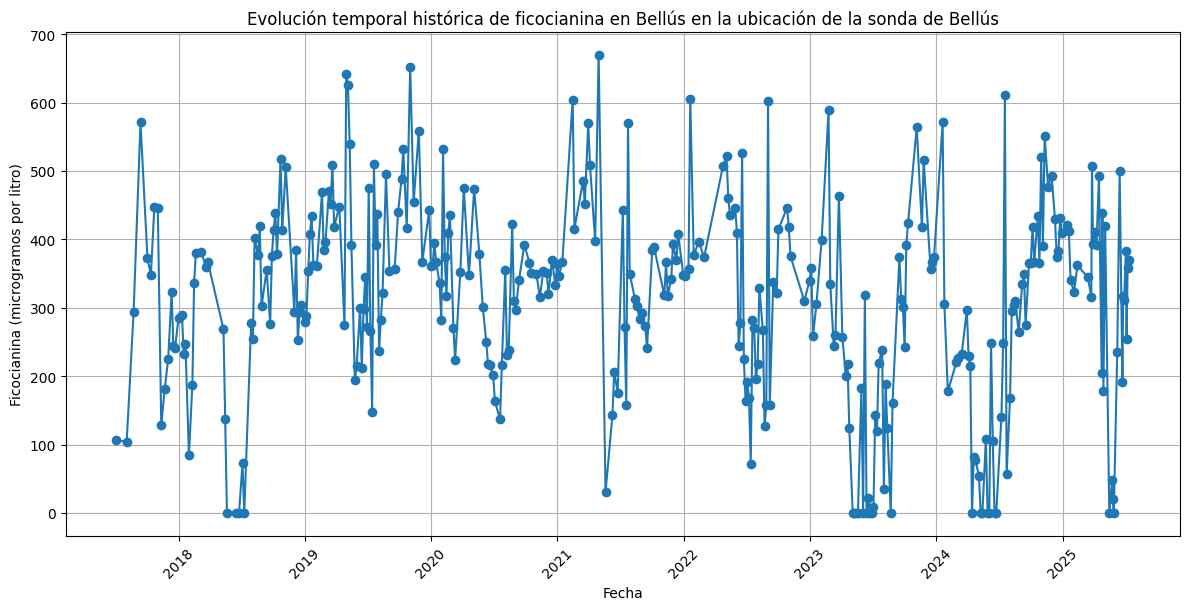

In [ ]:
import matplotlib.pyplot as plt

df_resultados['Date'] = pd.to_datetime(df_resultados['Date'])
df_resultados = df_resultados.dropna(subset=['PC_Bellus_cal'])
df_resultados = df_resultados[df_resultados['PC_Bellus_cal'] <= 800]
# Ordenar por fecha
df_resultados = df_resultados.sort_values('Date')

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df_resultados['Date'], df_resultados['PC_Bellus_cal'], marker='o', linestyle='-')
plt.title('Evolución temporal histórica de ficocianina en Bellús en la ubicación de la sonda de Bellús')
plt.xlabel('Fecha')
plt.ylabel('Ficocianina (microgramos por litro)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


# Clorofila en el Val

## Importación datos Clorofila en El Val

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [75]:
# Leer CSV sin sobrescribir 'df'
ruta_cloro = '/content/drive/MyDrive/HIBLOOMS/Clorofila_ElVal_2018_2024.csv'
df_cloro = pd.read_csv(ruta_cloro)

# Selección y limpieza
df_cloro = df_cloro[['Datetime', 'Clorofila (µg/L)', 'Temp. agua (ºC)', 'Profundidad (m)', 'pH', 'Turbidez (NTU)']].copy()
df_cloro = df_cloro.rename(columns={'Datetime': 'Fecha'})
df_cloro['Fecha'] = pd.to_datetime(df_cloro['Fecha'])
df_cloro = df_cloro[df_cloro['Profundidad (m)'] <= 1.5]
df_cloro = df_cloro.dropna(subset=['Clorofila (µg/L)'])

# Crear columnas auxiliares
df_cloro['Solo_Fecha'] = df_cloro['Fecha'].dt.date
df_cloro['Diff_11_10'] = df_cloro.apply(
    lambda row: abs(row['Fecha'] - pd.Timestamp(f"{row['Solo_Fecha']} 11:10")),
    axis=1
)

# Filtrar por cercanía a las 11:10
df_cloro_filtrado = df_cloro[df_cloro['Diff_11_10'] <= pd.Timedelta(hours=4)].copy()

# Agrupar y calcular media diaria de clorofila
df_cloro_resultado = df_cloro_filtrado.groupby('Solo_Fecha')['Clorofila (µg/L)'].mean().reset_index()

# Añadir columna 'Fecha' con hora 11:10
df_cloro_resultado['Fecha'] = pd.to_datetime(df_cloro_resultado['Solo_Fecha'].astype(str)) + pd.Timedelta(hours=11, minutes=10)
df_cloro_resultado = df_cloro_resultado.sort_values('Fecha').reset_index(drop=True)

# Renombrar columna final
df_cloro_resultado.rename(columns={'Clorofila (µg/L)': 'clorofila'}, inplace=True)



In [76]:
df_cloro_resultado

,Solo_Fecha,clorofila,Fecha
0,2018-01-21,22.40,2018-01-21 11:10:00
1,2018-01-22,21.50,2018-01-22 11:10:00
2,2018-01-23,27.90,2018-01-23 11:10:00
3,2018-01-24,32.70,2018-01-24 11:10:00
4,2018-01-25,38.00,2018-01-25 11:10:00
...,...,...,...
2170,2024-06-26,45.90,2024-06-26 11:10:00
2171,2024-06-27,28.80,2024-06-27 11:10:00
2172,2024-06-28,28.55,2024-06-28 11:10:00
2173,2024-06-29,28.10,2024-06-29 11:10:00


In [ ]:
from google.colab import files

df.to_csv('df_limpio.csv', index=False)
files.download('df_limpio.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

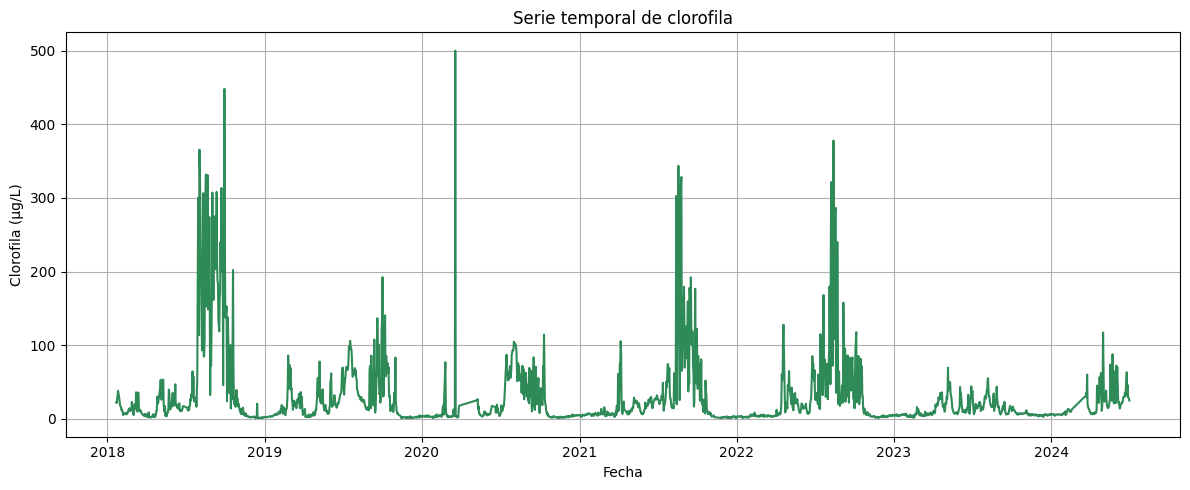

In [ ]:
import pandas as pd#MODIFICAR DF_CLORO_RESULTADO
import matplotlib.pyplot as plt

# Asegurar formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Ordenar por fecha por si acaso
df = df.sort_values('Fecha')

# Crear gráfico
plt.figure(figsize=(12, 5))
plt.plot(df['Fecha'], df['clorofila'], color='seagreen', linewidth=1.5)

# Personalizar gráfico
plt.title('Serie temporal de clorofila')
plt.xlabel('Fecha')
plt.ylabel('Clorofila (µg/L)')
plt.grid(True)
plt.tight_layout()
plt.show()


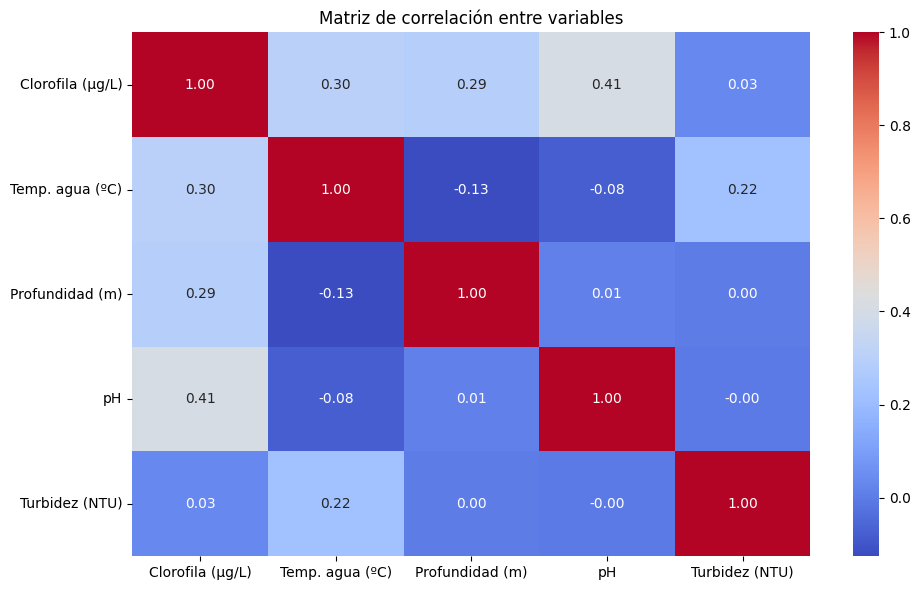

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

variables = ["Clorofila (µg/L)", "Temp. agua (ºC)", "Profundidad (m)", "pH", "Turbidez (NTU)"]
# Calcular la matriz de correlación
corr = df[variables].corr()

# Dibujar la matriz como un mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables")
plt.tight_layout()
plt.show()


## Análisis Clorofila vs NDCI

In [47]:
import ee
import pandas as pd
from datetime import datetime

# Inicializar Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-nicolasgoyenaserveto')

# Rango completo
fecha_inicio = "2017-07-01"
fecha_fin = "2024-06-30"  # Incluye hasta el 30 de junio

# Punto de medición
lat = 41.8758
lon = -1.7872
punto_sonda = ee.Geometry.Point([lon, lat])

# Filtrar colección
coleccion = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(punto_sonda) \
    .filterDate(fecha_inicio, fecha_fin)

# Obtener fechas únicas
fechas_unicas = sorted(set([
    datetime.utcfromtimestamp(ts / 1000).strftime("%Y-%m-%d")
    for ts in coleccion.aggregate_array('system:time_start').getInfo()
]))

print(f"📆 Procesando del {fecha_inicio} al {fecha_fin} con {len(fechas_unicas)} fechas disponibles")

resultados = []

for fecha in fechas_unicas:
    try:
        inicio_ee = ee.Date(fecha)
        fin_ee = inicio_ee.advance(1, 'day')

        imagen = coleccion.filterDate(inicio_ee, fin_ee) \
                          .filterBounds(punto_sonda) \
                          .sort('CLOUDY_PIXEL_PERCENTAGE') \
                          .first()
        if imagen is None:
            continue

        timestamp = imagen.get('system:time_start').getInfo()
        fecha_hora = datetime.utcfromtimestamp(timestamp / 1000).strftime("%Y-%m-%d %H:%M:%S")
        imagen = ee.Image(imagen).clip(punto_sonda)

        scl = imagen.select('SCL')
        clase_punto = scl.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=punto_sonda,
            scale=20
        ).get('SCL')

        try:
            valor_clase = clase_punto.getInfo()
        except:
            valor_clase = None

        if valor_clase in [7, 8, 9, 10]:
            print(f"{fecha_hora}: cubierto por nubes (SCL={valor_clase})")
            continue

        b4 = imagen.select('B4').divide(10000)
        b5 = imagen.select('B5').divide(10000)

        ndci = b5.subtract(b4).divide(b5.add(b4)).rename('NDCI')
        ndci_valor = ndci.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=punto_sonda,
            scale=20
        ).get('NDCI')

        try:
            valor_ndci = ndci_valor.getInfo()
        except Exception as e:
            print(f"{fecha_hora}: error al obtener NDCI: {e}")
            valor_ndci = None

        resultados.append({"Fecha": fecha_hora, "NDCI": valor_ndci})
        print(f"{fecha_hora}: NDCI = {valor_ndci}")

    except Exception as e:
        print(f"⚠️ Error procesando {fecha}: {e}")
        continue

# Crear DataFrame y guardar
df = pd.DataFrame(resultados)
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Guardar CSV final
nombre_archivo = "PuntoSonda_NDCI_2018_2024.csv"
df.to_csv(nombre_archivo, index=False)
print(f"✅ CSV final guardado: {nombre_archivo} con {len(df)} registros")



KeyboardInterrupt: 

In [ ]:
from google.colab import files
files.download("PuntoSonda_NDCI_2018_2024.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
import pandas as pd

# 1. Cargar datos
ndci_df = pd.read_csv("/content/drive/MyDrive/HIBLOOMS/PuntoSonda_NDCI_2018_2024.csv") #El archivo está en el repositorio
ndci_df["Fecha"] = pd.to_datetime(ndci_df["Fecha"])
df_cloro_resultado["Fecha"] = pd.to_datetime(df_cloro_resultado["Fecha"])

ndci_df["Solo_Fecha_tmp"] = ndci_df["Fecha"].dt.date
df_cloro_resultado["Solo_Fecha_tmp"] = df_cloro_resultado["Fecha"].dt.date

resultados = []

for dia in ndci_df["Solo_Fecha_tmp"].unique():
    ndci_dia = ndci_df[ndci_df["Solo_Fecha_tmp"] == dia].sort_values("Fecha").drop(columns="Solo_Fecha_tmp")
    df_dia = df_cloro_resultado[df_cloro_resultado["Solo_Fecha_tmp"] == dia].sort_values("Fecha").drop(columns="Solo_Fecha_tmp")

    if not df_dia.empty:
        merged = pd.merge_asof(ndci_dia, df_dia, on="Fecha", direction="nearest")
        resultados.append(merged)

ndci_completo = pd.concat(resultados, ignore_index=True)
ndci_completo.sort_values("Fecha", inplace=True)

# 7. Guardar resultado
ndci_completo.to_csv("PuntoSonda_NDCI_Clorofila.csv", index=False)
print("✅ CSV combinado guardado correctamente.")


✅ CSV combinado guardado correctamente.


In [71]:
ndci_completo

,Fecha,NDCI,Solo_Fecha,clorofila
0,2018-01-24 11:03:32,-0.106017,2018-01-24,32.70
1,2018-01-29 11:03:06,0.055556,2018-01-29,21.50
2,2018-03-15 11:06:09,-0.061224,2018-03-15,10.10
3,2018-03-30 11:00:02,-0.060665,2018-03-30,4.70
4,2018-04-04 11:02:49,0.018510,2018-04-04,3.15
...,...,...,...,...
238,2024-04-22 11:09:37,0.013274,2024-04-22,56.65
239,2024-04-27 11:09:29,0.025148,2024-04-27,10.90
240,2024-05-02 11:09:33,0.005093,2024-05-02,24.05
241,2024-06-16 11:09:33,-0.028571,2024-06-16,29.50


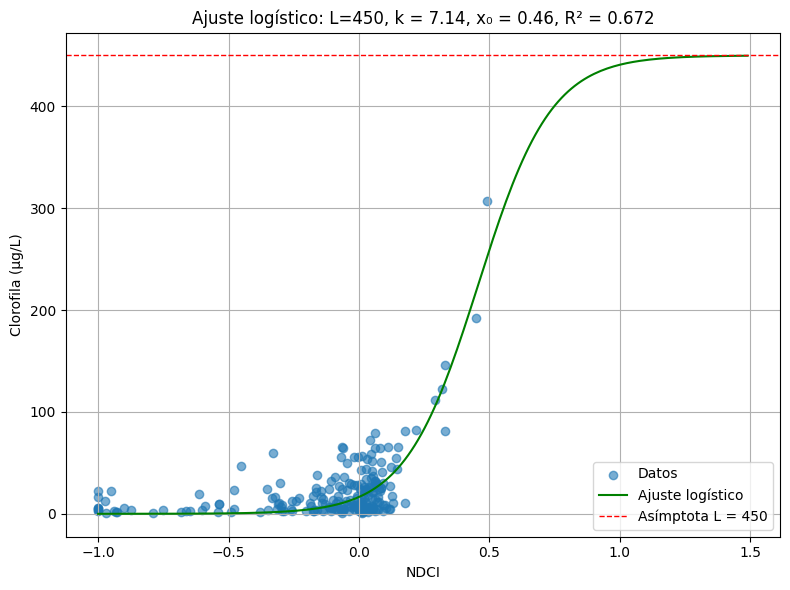

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# 1. Cargar el CSV ya limpio
df = pd.read_csv("/content/drive/MyDrive/HIBLOOMS/PuntoSonda_NDCI_Clorofila.csv") #El archivo está en el repositorio
x = df["NDCI"].values
y = df["clorofila"].values

# 2. Definir el modelo logístico con L fijo
L_manual = 450

def modelo_logistico_Lfijo(x, k, x0):
    return L_manual / (1 + np.exp(-k * (x - x0)))

# 3. Ajuste de parámetros k y x0
popt, _ = curve_fit(modelo_logistico_Lfijo, x, y, p0=[1, 0.4], maxfev=10000)
k_opt, x0_opt = popt

# 4. Calcular predicciones y R²
y_pred = modelo_logistico_Lfijo(x, *popt)
r2 = r2_score(y, y_pred)

# 5. Crear datos para la curva ajustada
x_fit = np.linspace(min(x), max(x)+1, 200)
y_fit = modelo_logistico_Lfijo(x_fit, *popt)

# 6. Graficar resultados
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, label="Datos")
plt.plot(x_fit, y_fit, color='green', label="Ajuste logístico")
plt.axhline(L_manual, color='red', linestyle='--', linewidth=1, label=f"Asímptota L = {L_manual}")
plt.title(f"Ajuste logístico: L=450, k = {k_opt:.2f}, x₀ = {x0_opt:.2f}, R² = {r2:.3f}")
plt.xlabel("NDCI")
plt.ylabel("Clorofila (µg/L)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


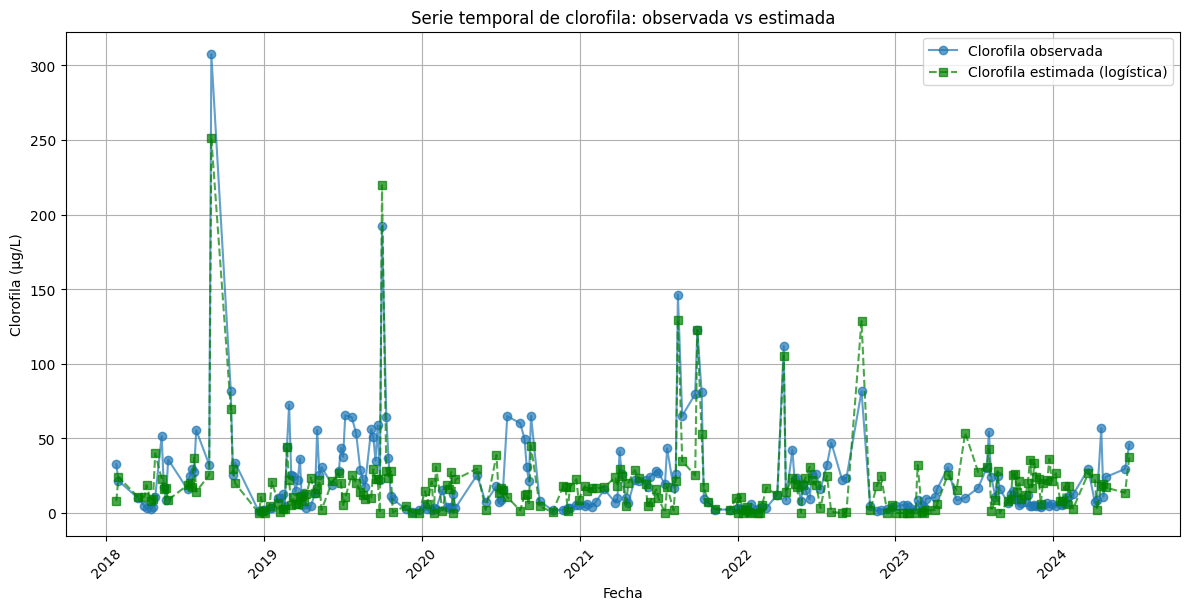

In [86]:
import matplotlib.pyplot as plt

# Asegurar que 'Solo_Fecha' esté en formato datetime (por si acaso)
df["Solo_Fecha"] = pd.to_datetime(df["Solo_Fecha"])

# Ordenar por fecha (opcional pero recomendable)
df = df.sort_values("Solo_Fecha")

# Graficar clorofila observada vs clorofila estimada por la función logística
plt.figure(figsize=(12, 6))
plt.plot(df["Solo_Fecha"], df["clorofila"], label="Clorofila observada", marker='o', linestyle='-', alpha=0.7)
plt.plot(df["Solo_Fecha"], df["clorofila_logistica_Lfijo"], label="Clorofila estimada (logística)", marker='s', linestyle='--', alpha=0.7, color='green')

plt.title("Serie temporal de clorofila: observada vs estimada")
plt.xlabel("Fecha")
plt.ylabel("Clorofila (µg/L)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()



## Cálculo serie histórica Clorofila en El Val

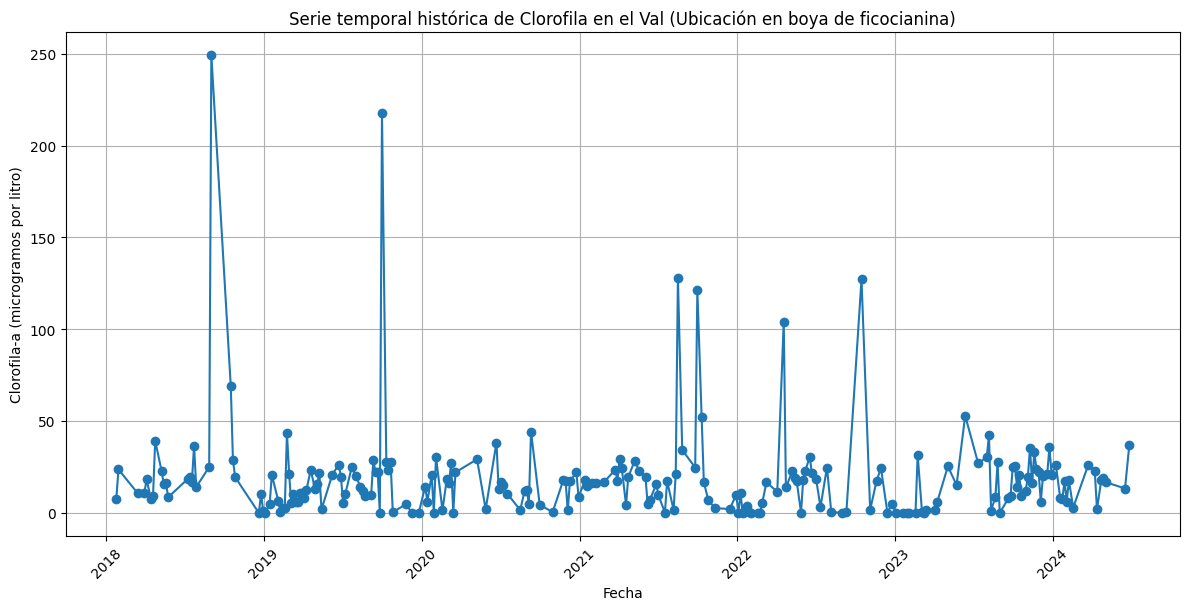

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Eliminar NaN de la columna NDCI
df = df.dropna(subset=['NDCI'])

# Calcular nueva columna Chla_Val_cal a partir de NDCI
def calcular_chla_val(ndci):
    return 450 / (1 + np.exp(-7.14 * (ndci - 0.46)))

df['Chla_Val_cal'] = df['NDCI'].apply(calcular_chla_val)

# Eliminar valores negativos si hubiera (equivalente a .max(0))
df['Chla_Val_cal'] = df['Chla_Val_cal'].clip(lower=0)

# Convertir la fecha si no está en datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha')

# Graficar serie temporal
plt.figure(figsize=(12, 6))
plt.plot(df['Fecha'], df['Chla_Val_cal'], marker='o', linestyle='-')
plt.title('Serie temporal histórica de Clorofila en el Val (Ubicación en boya de ficocianina)')
plt.xlabel('Fecha')
plt.ylabel('Clorofila-a (microgramos por litro)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


## Calculo serie histórica de Clorofila en Bellús

In [ ]:
import ee
import pandas as pd
from datetime import datetime

# Inicializar Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-nicolasgoyenaserveto')

# Rango completo
fecha_inicio = "2017-07-01"
fecha_fin = "2025-07-14"

# Punto de medición
lat = 38.936974
lon = -0.479160
punto_sonda = ee.Geometry.Point([lon, lat])

# Filtrar colección
coleccion = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(punto_sonda) \
    .filterDate(fecha_inicio, fecha_fin)

# Obtener fechas únicas
fechas_unicas = sorted(set([
    datetime.utcfromtimestamp(ts / 1000).strftime("%Y-%m-%d")
    for ts in coleccion.aggregate_array('system:time_start').getInfo()
]))

print(f"📆 Procesando del {fecha_inicio} al {fecha_fin} con {len(fechas_unicas)} fechas disponibles")

resultados = []

for fecha in fechas_unicas:
    try:
        inicio_ee = ee.Date(fecha)
        fin_ee = inicio_ee.advance(1, 'day')

        imagen = coleccion.filterDate(inicio_ee, fin_ee) \
                          .filterBounds(punto_sonda) \
                          .sort('CLOUDY_PIXEL_PERCENTAGE') \
                          .first()
        if imagen is None:
            continue

        timestamp = imagen.get('system:time_start').getInfo()
        fecha_hora = datetime.utcfromtimestamp(timestamp / 1000).strftime("%Y-%m-%d %H:%M:%S")
        imagen = ee.Image(imagen).clip(punto_sonda)

        scl = imagen.select('SCL')
        clase_punto = scl.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=punto_sonda,
            scale=20
        ).get('SCL')

        try:
            valor_clase = clase_punto.getInfo()
        except:
            valor_clase = None

        if valor_clase in [7, 8, 9, 10]:
            print(f"{fecha_hora}: cubierto por nubes (SCL={valor_clase})")
            continue

        # Bandas necesarias
        b4 = imagen.select('B4').divide(10000)  # 665 nm
        b5 = imagen.select('B5').divide(10000)  # 705 nm

        # Calcular NDCI (NDI)
        ndci = b5.subtract(b4).divide(b5.add(b4)).rename('NDCI')
        ndci_valor = ndci.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=punto_sonda,
            scale=20
        ).get('NDCI')

        try:
            valor_ndci = ndci_valor.getInfo()
        except Exception as e:
            print(f"{fecha_hora}: error al obtener NDCI: {e}")
            valor_ndci = None

        # Calcular Chla_Bellus_cal = 112.78 * NDCI + 10.779
        if valor_ndci is not None:
            valor_chla = 112.78 * valor_ndci + 10.779
        else:
            valor_chla = None

        resultados.append({
            "Fecha": fecha_hora,
            "NDCI": valor_ndci,
            "Chla_Bellus_cal": valor_chla
        })
        print(f"{fecha_hora}: NDCI = {valor_ndci}, Chla_Bellus_cal = {valor_chla}")

    except Exception as e:
        print(f"⚠️ Error procesando {fecha}: {e}")
        continue

# Crear DataFrame y guardar
df = pd.DataFrame(resultados)
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Guardar CSV final
nombre_archivo = "PuntoSonda_NDCI_ChlaBellus_2017_2025.csv"
df.to_csv(nombre_archivo, index=False)
print(f"✅ CSV final guardado: {nombre_archivo} con {len(df)} registros")


📆 Procesando del 2017-07-01 al 2025-07-14 con 572 fechas disponibles
2017-07-05 10:56:05: NDCI = 0.18781006378454998, Chla_Bellus_cal = 31.960218993621545
2017-08-04 10:53:28: NDCI = 0.13644859813084115, Chla_Bellus_cal = 26.167672897196265
2017-08-24 10:52:40: NDCI = 0.3985330073349634, Chla_Bellus_cal = 55.72555256723717
2017-09-03 10:55:15: cubierto por nubes (SCL=10)
2017-09-13 10:53:35: NDCI = 0, Chla_Bellus_cal = 10.779
2017-09-23 10:57:17: cubierto por nubes (SCL=9)
2017-10-03 10:58:56: NDCI = 0.3653846153846154, Chla_Bellus_cal = 51.98707692307693
2017-10-13 10:53:15: NDCI = 0.23178807947019867, Chla_Bellus_cal = 36.920059602649005
2017-10-23 10:51:54: NDCI = 0.3787465940054496, Chla_Bellus_cal = 53.4940408719346
2017-11-02 10:59:41: NDCI = 0.35135135135135137, Chla_Bellus_cal = 50.40440540540541
2017-11-12 10:59:42: NDCI = 0.32903225806451614, Chla_Bellus_cal = 47.88725806451613
2017-11-22 10:56:12: NDCI = 0.27868852459016397, Chla_Bellus_cal = 42.209491803278695
2017-12-02 10

2020-09-12 11:00:17: NDCI = 0.45323741007194246, Chla_Bellus_cal = 61.89511510791367
2020-09-17 11:00:19: cubierto por nubes (SCL=9)
2020-09-22 11:00:17: cubierto por nubes (SCL=8)
2020-09-27 11:00:20: NDCI = 0.3415637860082304, Chla_Bellus_cal = 49.300563786008226
2020-10-02 11:00:18: cubierto por nubes (SCL=9)
2020-10-07 11:00:20: cubierto por nubes (SCL=10)
2020-10-12 11:00:18: NDCI = 0.37777777777777777, Chla_Bellus_cal = 53.38477777777777
2020-10-17 11:00:20: NDCI = 0.1617647058823529, Chla_Bellus_cal = 29.02282352941176
2020-10-27 11:00:20: cubierto por nubes (SCL=8)
2020-11-01 11:00:17: NDCI = 0.2213114754098361, Chla_Bellus_cal = 35.73850819672131
2020-11-06 11:00:19: cubierto por nubes (SCL=8)
2020-11-11 11:00:16: NDCI = 0.16972477064220176, Chla_Bellus_cal = 29.920559633027516
2020-11-16 11:00:18: cubierto por nubes (SCL=8)
2020-11-21 11:00:15: NDCI = 0.143824027072758, Chla_Bellus_cal = 26.999473773265645
2020-11-26 11:00:15: cubierto por nubes (SCL=9)
2020-12-01 11:00:14: N

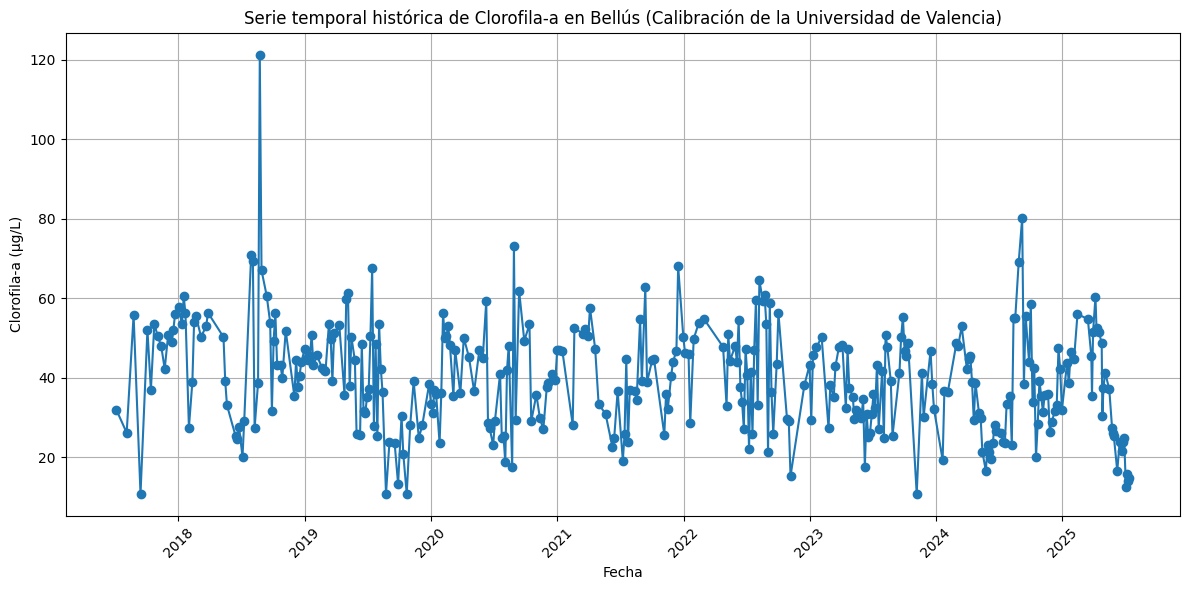

In [ ]:
import matplotlib.pyplot as plt

# Asegurar que la columna de fecha es tipo datetime y está ordenada
df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha')

# Eliminar valores nulos
df = df.dropna(subset=['Chla_Bellus_cal'])

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['Fecha'], df['Chla_Bellus_cal'], marker='o', linestyle='-')
plt.title('Serie temporal histórica de Clorofila-a en Bellús (Calibración de la Universidad de Valencia)')
plt.xlabel('Fecha')
plt.ylabel('Clorofila-a (μg/L)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
